#### [ Pytorch DL MODEL 실습 ]

- 데이터셋 : iris.csv 
- 학습방법 : 지도학습 + 분류 ==>  다중분류

[1] 모듈로딩 및 데이터 준비<hr>

In [2]:
## 모듈로딩
import pandas as pd                                     ## 데이터 관련 모듈들
import numpy as np 

import torch                                            ## Tensor 및 기본 함수들 관련 모듈들
import torch.nn as nn                                   ## 인공신경망 관련 모듈들
import torch.nn.functional as F                         ## 인공신경망 관련 함수들
import torch.optim as optim                             ## 최적화 모듈
from torch.utils.data import Dataset, DataLoader        ## 학습 데이터셋 관련 모듈

from sklearn.model_selection import train_test_split    ## 학습용 데이터셋 관련 함수

In [3]:
## 데이터 준비
DATA_FILE = '../data/file/iris.csv'

[2] 데이터 로딩 및 확인<hr>

In [4]:
## 데이터 로딩
irisDF = pd.read_csv(DATA_FILE)

irisDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal.length  150 non-null    float64
 1   sepal.width   150 non-null    float64
 2   petal.length  150 non-null    float64
 3   petal.width   150 non-null    float64
 4   variety       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [5]:
## 데이터 확인
irisDF.variety.unique()

array(['Setosa', 'Versicolor', 'Virginica'], dtype=object)

In [6]:
pd.set_option('future.no_silent_downcasting', True)
irisDF.variety=irisDF.variety.replace({'Setosa':0, 'Versicolor':1, 'Virginica':2})

In [7]:
irisDF.variety=irisDF.variety.astype('int')
irisDF.dtypes

sepal.length    float64
sepal.width     float64
petal.length    float64
petal.width     float64
variety           int64
dtype: object

[3] 데이터 셋 준비<hr>

In [8]:
## 피쳐와 타겟 분리 
featureDF =irisDF[irisDF.columns[:-1]]   # Feature 4개
targetSR = irisDF[irisDF.columns[-1]]    # 품종 1개

print(f'[FeatureDF] {featureDF.shape}, {featureDF.ndim}D')
print(f'[targetSR]  {targetSR.shape},  {targetSR.ndim}D')

[FeatureDF] (150, 4), 2D
[targetSR]  (150,),  1D


In [9]:
## 학습용, 테스트용 데이터셋 분리 
X_train, X_test, y_train, y_test = train_test_split(featureDF, 
                                                    targetSR, 
                                                    test_size=0.2,
                                                    stratify=targetSR,
                                                    random_state=42)

print(f'[X_train] {X_train.shape}, {X_train.ndim}D  [y_train] {y_train.shape}, {y_train.ndim}D')
print(f'[X_test]  {X_test.shape}, {X_test.ndim}D  [y_test] {y_test.shape}, {y_test.ndim}D')


[X_train] (120, 4), 2D  [y_train] (120,), 1D
[X_test]  (30, 4), 2D  [y_test] (30,), 1D


In [10]:
## 인덱스 재설정 
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

In [11]:
# Series => DataFrame : to_frame()
y_train= y_train.to_frame()
y_test = y_test.to_frame()

print(f'y_train : {y_train.shape}   y_test : {y_test.shape}')

y_train : (120, 1)   y_test : (30, 1)


[4] 커스텀 데이터셋 클래스 설계 및 구현 <hr>

In [12]:
## iris 전용 데이터셋 클래스 
class IrisDataset(Dataset):
    # 피쳐와 타겟 분리 및 전처리 진행 
    def __init__(self, featureDF, targetDF):
        super().__init__()
        self.feature = featureDF
        self.target  = targetDF
        self.rows = featureDF.shape[0]
        self.cols = featureDF.shape[1]
    
    # 데이터셋의 샘플 수 반환 메서드 
    def __len__(self):
        return self.rows 

    # DataLoader에서 batch_size만큼 호출하는 메서드
    # 인덱스에 해당하는 피쳐와 타겟 반환 단, Tensor 형태
    def __getitem__(self, index):
       arrFeature = self.feature.iloc[index].values   # ndarray
       arrTarget = self.target.iloc[index].values    # ndarray
   
       return torch.FloatTensor(arrFeature), torch.FloatTensor(arrTarget)

In [13]:
## 확인 => Train용 DataSet 필수 
##     => Test용 Dataset 선택 => 데이터가 많다면 DS, DL 생성 사용
##                           => 데이터가 많지 않다면 DS, DL 생성 필요 X 
trainDS = IrisDataset(X_train, y_train)
testDS  = IrisDataset(X_test, y_test)
print( trainDS[1] )
print( testDS[1] )

(tensor([4.9000, 2.5000, 4.5000, 1.7000]), tensor([2.]))
(tensor([6.1000, 3.0000, 4.9000, 1.8000]), tensor([2.]))


In [14]:
## DataLoader로 확인
trainDL = DataLoader(dataset=trainDS, batch_size=3)
for feature, label in trainDL:
    print(feature, label, sep='\n')
    break

tensor([[4.4000, 2.9000, 1.4000, 0.2000],
        [4.9000, 2.5000, 4.5000, 1.7000],
        [6.8000, 2.8000, 4.8000, 1.4000]])
tensor([[0.],
        [2.],
        [1.]])


In [15]:
# 테스트용 데이터로더
testDL = DataLoader(dataset=testDS, batch_size=3)
for feature, label in testDL:
    print(feature, label, sep='\n')
    break

tensor([[4.4000, 3.0000, 1.3000, 0.2000],
        [6.1000, 3.0000, 4.9000, 1.8000],
        [4.9000, 2.4000, 3.3000, 1.0000]])
tensor([[0.],
        [2.],
        [1.]])


[4] 모델 설계 및 클래스 구현<hr>

In [16]:
# 모델 클래스 설계 ----------------------------------------------------------------------
## 회귀용 커스텀 모델 
## 클래스이름 : IrisModel
## 부모클래스 : nn.Module
## 모델층구성   입력신호/피쳐수       출력신호수/퍼셉트론수       활성화함수
## - 입력층  :      4                     100                 ReLu
## - 은닉층  :     100                     30                 ReLu 
## - 출력층  :      30                     3                  Softmax => 손실함수 내 포함
## - -----------------------------------------------------------------------------------
class IrisModel(nn.Module):
    ## 모델 층 설계 및 초기화 메서드 
    def __init__(self):
        super().__init__()
        self.in_layer  = nn.Linear(4,  100)
        self.hd_layer  = nn.Linear(100, 30)
        self.out_layer = nn.Linear(30,  3)

    ## 학습 진행 메서드 
    def forward(self, data):
        ## 입력층
        out = F.relu( self.in_layer(data) )
        ## 은닉층
        out = F.relu( self.hd_layer(out) )
        ## 출력층
        return self.out_layer(out) 
    

In [17]:
## 모델 구조 확인
model = IrisModel()
print( model )

## shape 체크
data = torch.FloatTensor( [[1.,3.2, 1.9, 2.6]] )   # (1, 4)
model(data)

IrisModel(
  (in_layer): Linear(in_features=4, out_features=100, bias=True)
  (hd_layer): Linear(in_features=100, out_features=30, bias=True)
  (out_layer): Linear(in_features=30, out_features=3, bias=True)
)


tensor([[-0.1165,  0.0125, -0.1236]], grad_fn=<AddmmBackward0>)

In [18]:

## shape 체크
for feature, target  in testDS:
    pre_ = model(feature)
    print(pre_)
    break

tensor([-0.2783, -0.1478, -0.2097], grad_fn=<ViewBackward0>)


[5] 학습 준비 <hr>

- [5-1]학습 관련 설정들

In [19]:

EPOCHS      = 70                                   # 학습용 DS을 처음부터 끝까지 1번 학습하는 것을 에포크
BATCH_SIZE  = 40                                    # DS을 학습량 만큼 나눈 사이즈 
ITERATION   = int(X_train.shape[0]/BATCH_SIZE)      # 학습용 DS이 분리된 수 => 1에포크에 W, b 업데이트 횟수

# 학습, 데이터셋 로딩 등 GPU에서 실행 여부 설정 
DEVICE      = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'DEVICE : {DEVICE}, EPOCHS : {EPOCHS}, BATCH_SIZE : {BATCH_SIZE} ITERATION : {ITERATION}')

DEVICE : cpu, EPOCHS : 70, BATCH_SIZE : 40 ITERATION : 3


- [5-2] 학습 관련 인스턴스들

In [20]:
TRAINDL   = DataLoader(trainDS, batch_size=BATCH_SIZE)
TESTDL    = DataLoader(testDS,  batch_size=BATCH_SIZE)
LR        = 0.01  
MODEL     = IrisModel()                             ## 학습 모델
OPTIMIZER = optim.Adam(MODEL.parameters(), lr=LR)   ## 최적화 즉, 경사하강법 알고리즘으로 W, b의 값 갱신
LOSS_FN   = nn.CrossEntropyLoss()                   ## 다중분류 손실함수


- [5-3] 학습관련 함수들

In [22]:

##- 검증 함수 --------------------------------------------
##- 검증용 데이터셋으로 모델 검증
##- 학습 지속여부 결정 기준이 됨
##- -----------------------------------------------------
def evaluate():
    # 에포크 단위로 검증 => 검증 모드
    MODEL.eval()
    
    # W, b가 업데이트 해제
    with torch.no_grad():
        # T_LOSS, CNT = 0, 0
        # for feature, target in TESTDL:            
        #     # 검증진행
        #     pre_y= MODEL(feature)
            
        #     # 손실 계산
        #     loss = LOSS_FN(pre_y, target.reshape(-1).long())
        #     T_LOSS += loss.item()
        #     CNT += 1
    #return T_LOSS/CNT
        # DF/SR => Tensor화
        # 검증용 데이터셋 => 텐서화 ndarray ==> tensor변환
        x = torch.FloatTensor(X_test.values) 
        y = torch.FloatTensor(y_test.values)
        
        # 검증진행
        pre_y= MODEL(x)
        
        # 손실 계산
        loss = LOSS_FN(pre_y, y.reshape(-1).long())

    return loss.item()

In [23]:
##- 학습 함수 --------------------------------------------
##- 학습용 데이터셋으로 모델 검증
##- -----------------------------------------------------
def training():
    # 학습 모드 설정
    model.train()

    E_LOSS=0
    #for i in range(ITERATION): 
    for feature, target in TRAINDL:
                                                                    
        # 가중치 기울기 0 초기화
        OPTIMIZER.zero_grad()

        # 학습 진행
        pre_y = MODEL(feature)

        # 손실 계산
        loss = LOSS_FN(pre_y, target.reshape(-1).long())
        
        # 역전파 진행
        loss.backward()

        # 가중치/절편 업데이트
        OPTIMIZER.step()

        E_LOSS += loss.item()

    return E_LOSS/ITERATION

In [24]:
# 에포크 : DS 처음부터 ~ 끝까지 학습  
LOSS_HIST ={'Train':[], 'Valid':[]}   

# 에포크 단위 학습/검증 진행 
for epoch in range(EPOCHS):
    trainLoss = training()
    validLoss = evaluate()

    LOSS_HIST['Train'].append(trainLoss)
    LOSS_HIST['Valid'].append(validLoss)

    print(f'\nEPOCH[{epoch}/{EPOCHS}]----------------')
    print(f'- TRAIN_LOSS {trainLoss:.5f}')
    print(f'- VALID_LOSS {validLoss:.5f}')


EPOCH[0/70]----------------
- TRAIN_LOSS 1.07741
- VALID_LOSS 0.89799

EPOCH[1/70]----------------
- TRAIN_LOSS 0.82469
- VALID_LOSS 0.63563

EPOCH[2/70]----------------
- TRAIN_LOSS 0.58207
- VALID_LOSS 0.48337

EPOCH[3/70]----------------
- TRAIN_LOSS 0.43257
- VALID_LOSS 0.37007

EPOCH[4/70]----------------
- TRAIN_LOSS 0.34069
- VALID_LOSS 0.29643

EPOCH[5/70]----------------
- TRAIN_LOSS 0.26751
- VALID_LOSS 0.23896

EPOCH[6/70]----------------
- TRAIN_LOSS 0.21310
- VALID_LOSS 0.19022

EPOCH[7/70]----------------
- TRAIN_LOSS 0.16423
- VALID_LOSS 0.14549

EPOCH[8/70]----------------
- TRAIN_LOSS 0.13052
- VALID_LOSS 0.11888

EPOCH[9/70]----------------
- TRAIN_LOSS 0.10691
- VALID_LOSS 0.09852

EPOCH[10/70]----------------
- TRAIN_LOSS 0.08904
- VALID_LOSS 0.07751

EPOCH[11/70]----------------
- TRAIN_LOSS 0.08153
- VALID_LOSS 0.06899

EPOCH[12/70]----------------
- TRAIN_LOSS 0.07541
- VALID_LOSS 0.06393

EPOCH[13/70]----------------
- TRAIN_LOSS 0.06979
- VALID_LOSS 0.05372

E

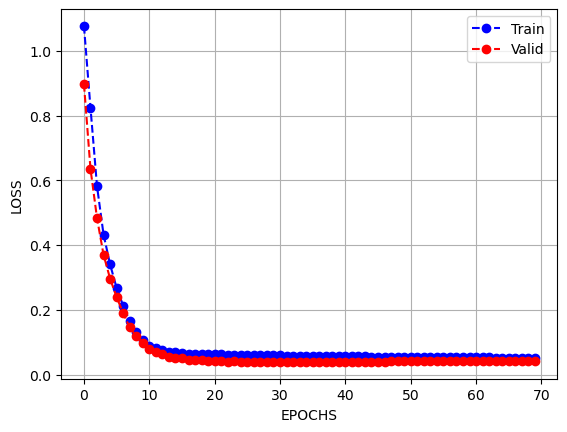

In [25]:
## 모델 성능 시각화 
import matplotlib.pyplot as plt

plt.plot(LOSS_HIST['Train'], 'bo--', label='Train')
plt.plot(LOSS_HIST['Valid'], 'ro--', label='Valid')
plt.grid()
plt.legend()
plt.xlabel('EPOCHS')
plt.ylabel('LOSS')
plt.show()